# Statistics review 9: One-way analysis of variance

R code accompanying [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC420045/pdf/cc2836.pdf)

## Key learning points

- How to test differences between more than two groups or treatments
- Multiple comparison procedures
- Orthogonal contrasts
- Pairwise comparisons

In [162]:
suppressPackageStartupMessages(library(tidyverse))
options(repr.plot.width=4, repr.plot.height=3)

## Multiple comparisons

For 4 groups, we can perform 6 pairwise comparisons. This inflates the error control from the expected 5% to 26%.

In [16]:
s = 0
for (n in 1:100) {
    df <- data.frame(x1=rnorm(10), x2=rnorm(10), x3=rnorm(10), x4=rnorm(10))
    for (i in 1:4) {
        for (j in 1:4) {
            if (i < j) {
            if (t.test(df[,i], df[,j])$p.val < 0.05) {
                s = s+1
                }
            }
        }
    }
}
s/100.0

[1] 0.25

## One-way analysis of variance

In [86]:
t1 <- c(10, 12, 14)
t2 <- c(19, 20, 21)
t3 <- c(14, 16, 18)
df <- data.frame(t1=t1, t2=t2, t3=t3)
df

t1,t2,t3
10,19,14
12,20,16
14,21,18


### Manual calculation

In [87]:
grand.mean <- mean(unlist(df))
grand.mean

[1] 16

In [88]:
treatment.mean <- df %>% summarize_each('mean')
treatment.mean

t1,t2,t3
12,20,16


In [90]:
df1 <- df %>% gather(treatment) %>%
mutate(explained.variance=as.numeric(rep(treatment.mean, each=3)) - grand.mean)  %>%
mutate(residual=value - as.numeric(rep(treatment.mean, each=3))) %>%
mutate(deviation=value - grand.mean)

df1

treatment,value,explained.variance,residual,deviation
t1,10,-4,-2,-6
t1,12,-4,0,-4
t1,14,-4,2,-2
t2,19,4,-1,3
t2,20,4,0,4
t2,21,4,1,5
t3,14,0,-2,-2
t3,16,0,0,0
t3,18,0,2,2


In [125]:
between.ss <- sum(df1$explained.variance^2)
between.df <- length(treatment.mean) - 1
between.ms <- between.ss/between.df
within.ss <- sum(df1$residual^2)
within.df <- dim(df1)[1] - 1 - between.df
within.ms <- within.ss/within.df

In [131]:
between.ms

[1] 48

In [132]:
within.ms

[1] 3

In [133]:
F <- between.ms/within.ms
F

[1] 16

In [137]:
round(1 - pf(F, df1=between.df, df2=within.df), 4)

[1] 0.0039

### Using built-in test

In [186]:
df2 <- df %>% gather(treatment, value)
df2$treatment <- as.factor(df2$treatment)

In [187]:
df2

treatment,value
t1,10
t1,12
t1,14
t2,19
t2,20
t2,21
t3,14
t3,16
t3,18


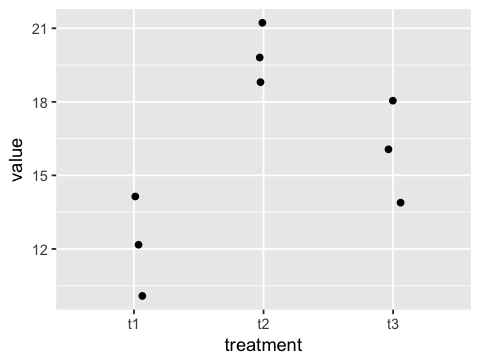

In [188]:
ggplot(df2, aes(x=treatment, y=value)) + geom_jitter(width=0.1)

In [189]:
fit <- aov(value ~ treatment, data=df2)
summary(fit)

            Df Sum Sq Mean Sq F value  Pr(>F)   
treatment    2     96      48      16 0.00394 **
Residuals    6     18       3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Multiple comparison procedures

In [167]:
pairwise.t.test(df2$value, df2$treatment, p.adjust.method = "none")


	Pairwise comparisons using t tests with pooled SD 

data:  df2$value and df2$treatment 

   t1     t2    
t2 0.0013 -     
t3 0.0300 0.0300

P value adjustment method: none 

In [168]:
pairwise.t.test(df2$value, df2$treatment, p.adjust.method = "bonferroni")


	Pairwise comparisons using t tests with pooled SD 

data:  df2$value and df2$treatment 

   t1     t2    
t2 0.0039 -     
t3 0.0901 0.0901

P value adjustment method: bonferroni 

### Duncan multiple range test

We will not use this test as it does not properly control for Type 1 error. We suggest you use TukeyHSD instead.

### Tukey's method

In [175]:
TukeyHSD(fit)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ treatment, data = df2)

$treatment
      diff        lwr        upr     p adj
t2-t1    8  3.6608047 12.3391953 0.0031658
t3-t1    4 -0.3391953  8.3391953 0.0673680
t3-t2   -4 -8.3391953  0.3391953 0.0673680


## Contrasts

In the regular one-way ANOVA, comparisons are made between treatments and the global mean. Other comparisons are possible, for example, between the mean of treatment 1 and the mean of treatments 2, 3 and 4. These alternative comparisons are known as contrasts. We show how to get different contrasts in R here.

In [190]:
levels(df2$treatment)

[1] "t1" "t2" "t3"

### Standard ANOVA

In [ ]:
            Df Sum Sq Mean Sq F value  Pr(>F)   
treatment    2     96      48      16 0.00394 **
Residuals    6     18       3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Zero-sum contrasts

In [253]:
mat <- contr.sum(3)

In [254]:
mat

1,1,0
2,0,1
3,-1,-1


In [255]:
contrasts(df2$treatment) <- mat

In [256]:
m <- aov(value ~ treatment, df2)

In [257]:
summary(m)

            Df Sum Sq Mean Sq F value  Pr(>F)   
treatment    2     96      48      16 0.00394 **
Residuals    6     18       3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [260]:
summary.aov(m, split=list(treatment=list("T2 vs T1 and T3"=1, "T1 vs T2 and T3" = 2))) 

                             Df Sum Sq Mean Sq F value  Pr(>F)   
treatment                     2     96      48      16 0.00394 **
  treatment: T2 vs T1 and T3  1     24      24       8 0.03002 * 
  treatment: T1 vs T2 and T3  1     72      72      24 0.00271 **
Residuals                     6     18       3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [225]:
t.test(df$t2, df$t3)


	Welch Two Sample t-test

data:  df$t2 and df$t3
t = 3.0984, df = 2.9412, p-value = 0.05479
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1553995  8.1553995
sample estimates:
mean of x mean of y 
       20        16 


### Polynomial contrasts

If the categorical variable is ordinal, we can use polynomial contrasts to look for a trend.

In [228]:
a1 <- c(24.4, 23.0, 25.4, 24.8, 23.6, 25.0, 23.4, 22.5, 21.7, 26.2)
a2 <- c(25.8, 25.6, 28.2, 22.6, 22.0, 23.8, 27.3, 22.8, 25.4, 26.1)
a3 <- c(26.1, 27.7, 21.8, 23.9, 27.7, 22.6, 26.0, 27.4, 26.6, 28.2)

pressure <- data.frame(a1=a1, a2=a2, a3=a3)
pressure

a1,a2,a3
24.4,25.8,26.1
23.0,25.6,27.7
25.4,28.2,21.8
24.8,22.6,23.9
23.6,22.0,27.7
25.0,23.8,22.6
23.4,27.3,26.0
22.5,22.8,27.4
21.7,25.4,26.6
26.2,26.1,28.2


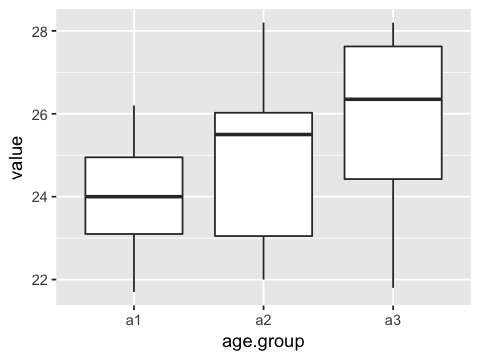

In [233]:
df3 <- pressure %>% gather(age.group, value)
df3$age.group <- as.factor(df3$age.group)
ggplot(df3, aes(x=age.group, y=value)) +
geom_boxplot()

### Regular ANOVA

In [234]:
model <- aov(value ~ age.group, data=df3)
summary(model)

            Df Sum Sq Mean Sq F value Pr(>F)
age.group    2  16.22   8.112   2.132  0.138
Residuals   27 102.74   3.805               

### Using polynomial contrasts to test for linear and quadratic trends

In [237]:
c1 <- c(-1, 0, 1)
c2 <- c(0.5, -1, 0.5)
mat <- cbind(c1,c2)
contrasts(df3$age.group) <- mat
model1 <- aov(value ~ age.group, data = df3)
summary.aov(model1, split=list(age.group=list("Linear"=1, "Quadratic" = 2)))

                       Df Sum Sq Mean Sq F value Pr(>F)  
age.group               2  16.22   8.112   2.132 0.1382  
  age.group: Linear     1  16.20  16.200   4.257 0.0488 *
  age.group: Quadratic  1   0.02   0.024   0.006 0.9373  
Residuals              27 102.74   3.805                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### We can also generate the contrast matrix automatically

In [251]:
mat <- contr.poly(3)
contrasts(df3$age.group) <- mat
model1 <- aov(value ~ age.group, data = df3)
summary.aov(model1, split=list(age.group=list("Linear"=1, "Quadratic" = 2)))

                       Df Sum Sq Mean Sq F value Pr(>F)  
age.group               2  16.22   8.112   2.132 0.1382  
  age.group: Linear     1  16.20  16.200   4.257 0.0488 *
  age.group: Quadratic  1   0.02   0.024   0.006 0.9373  
Residuals              27 102.74   3.805                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Conclusion

There is evidence for a linear trend in values across age groups.

## Exercise

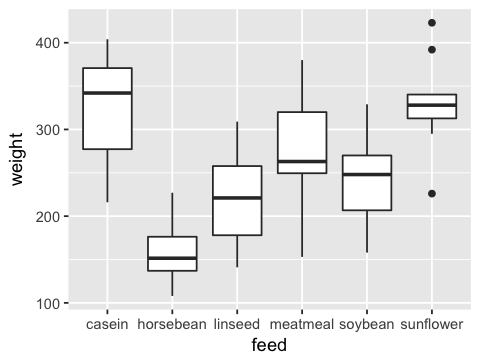

In [163]:
ggplot(chickwts, aes(x=feed, y=weight)) + geom_boxplot()

**1**. Perform a one-way analysis of variance for the effect of diet on chick weights in the `chickwts` data set.

**2**. Find which pairwise comparisons are statistically significant using Tukey's correction.